This notebook is based off of Fatima's `peak_fit_trend_SFR.ipynb` notebook and is designed to compute and plot the color ($u-r$) as a function of depth inside the V$^2$ voids.

This analysis requires binning the V$^2$ galaxies by their normalized depth inside a void and fitting the resulting distirbution in color.  We then compute the ratio of the means of the two skew normal distributions at each depth value.

In [1]:
import numpy as np

from astropy.table import Table
from astropy.io import fits

from scipy.optimize import curve_fit, minimize_scalar
from scipy.stats import skewnorm

from functions import model_skew, estimate_Jacobian, depth_plot

import matplotlib.pyplot as plt
%matplotlib inline

# Data

In [2]:
filename = '../../../../data/NSA_v1_0_1_VAGC_vflag-V2-VF.fits'

hdul = fits.open(filename)
data = Table(hdul[1].data)
hdul.close()

## Just keep the main SDSS DR7 footprint

In [3]:
# When the catalog is the NSA, only keep those objects which were originally in the DR7 LSS
catalog_SDSS = data[data['IN_DR7_LSS'] == 1]

ra_boolean = np.logical_and(catalog_SDSS['RA'] > 110, catalog_SDSS['RA'] < 270)
catalog_north = catalog_SDSS[ra_boolean]

strip_boolean = np.logical_and.reduce([catalog_north['RA'] > 250, 
                                       catalog_north['RA'] < 269, 
                                       catalog_north['DEC'] > 51, 
                                       catalog_north['DEC'] < 67])
catalog_main = catalog_north[~strip_boolean]

In [4]:
# Also only keep those within the redshift limit of the void catalogs
vollim = catalog_main[catalog_main['Z'] <= 0.114]

## Separate galaxies by their LSS classifications

### $V^2$

In [5]:
wall_v2 = catalog_main['vflag_V2'] == 0
void_v2 = catalog_main['vflag_V2'] == 1
edge_v2 = catalog_main['vflag_V2'] == 2
out_v2 = catalog_main['vflag_V2'] == 9

### VoidFinder

In [6]:
wall_vf = catalog_main['vflag_VF'] == 0
void_vf = catalog_main['vflag_VF'] == 1
edge_vf = catalog_main['vflag_VF'] == 2
out_vf = catalog_main['vflag_VF'] == 9

# color as a function of void depth

Bin the V$^2$ void galaxies by how far from their void boundary they are, and plot the ratio of the blue peak mean to the red peak mean in that bin as a function of the distance from the void boundary.  The plot will be cumulative from the inside of a void out, so we are really trying to find the "true" void galaxy population using V$^2$.

In [7]:
def func_bimodal(x, a, mua, sga, askew, b, mub, sgb, bskew):
    """
    Mixture of two skew normal distributions.
    

    Parameters
    ----------

    x : float or ndarray
        Values to calculate the model.
        
    a, b : float
        amplitudes of the skew normal distributions
        
    mua, mub : float
        locations of the skew normal distributions
        
    sga, sgb : float
        widths of the skew normal distributions
        
    askew, bskew : float
        skews of the skew normal distributions
    

    Returns
    -------
    model : float or ndarray
        Mixture model evaluated at x.
    """

    return a*skewnorm.pdf(x, askew, loc=mua, scale=sga) + \
           b*skewnorm.pdf(x, bskew, loc=mub, scale=sgb)

In [8]:
def bin_data(data, bins_, label="label me", plot=False): 

    n1, edges1 = np.histogram(data, bins=bins_)

    dn1 = np.sqrt(n1)

    x = 0.5*(edges1[1:] + edges1[:-1])
        
    if plot:
        plt.errorbar(x, n1, yerr=dn1, fmt='.')        
        plt.xlabel(label, fontsize=18)
        plt.ylabel('count',fontsize=18) 
        plt.title(label)
        plt.show()
        
    return  x, n1, dn1 #, popt_void

In [18]:
def fit_bimodal(char_, bins, class_=None, p0_=None, err=None, label=''):
    
    if class_ is None:
        x_data, y_data, dy = bin_data(data=char_, bins_=bins)
    else:
        x_data, y_data, dy = bin_data(data=char_[class_], bins_=bins)   
    
    if err is None:
        err = dy
    else:
        err[np.argwhere(err==0)] = 0.00001
    
    popt_, pcov_ = curve_fit(func_bimodal, x_data, y_data, p0=p0_)#, sigma=s)#, sigma=cov)
    
    ############################################################################
    # Plot distribution and best fit
    #---------------------------------------------------------------------------
    plt.errorbar(x_data, y_data, yerr=err, fmt='.')  
    plt.plot(x_data, func_bimodal(x_data, *popt_), 'k')
    plt.plot(x_data, model_skew(popt_[:4], x_data), 'b')
    plt.plot(x_data, model_skew(popt_[4:], x_data), 'r')
    plt.ylabel('Counts')
    plt.title(label)
    plt.show()
    ############################################################################
    
    print(popt_, np.sqrt(np.diag(pcov_)))
    
    #return popt_, np.sqrt(np.diag(pcov_))
    return popt_, pcov_

In [10]:
def ratio_uncertainty(fit, cov, x1, x2):
    '''
    Compute the uncertainty in the ratio of one peak to the other of the best-fit function.
    
    
    PARAMETERS
    ==========
    
    fit : list of length n
        Values of the best-fit parameters for the fit
        
    cov : ndarray of shape (n,n)
        Covariance matrix corresponding to the n best-fit parameters.
        
    x1, x2 : float
        The two x positions at which the best-fit function is evaluated for the ratio.  
        x1 is the value for the numerator of the ratio, and x2 is the value for the 
        denominator.
        
        
    RETURNS
    =======
    
    ratio_err : float
        Uncertainty in the ratio of the peaks in the best-fit.
    '''
    
    # Calculate the value of the best-fit function at x1, x2
    f1 = func_bimodal(x1, *fit)
    f2 = func_bimodal(x2, *fit)
    
    # Calculate the ratio
    ratio = f1/f2
    
    # Estimate the Jacobian of the best-fit function at x1, x2
    Jf1 = estimate_Jacobian(func_bimodal, x1, fit)
    Jf2 = estimate_Jacobian(func_bimodal, x2, fit)
    
    # Calculate the uncertainty of the best-fit-function at x1, x2
    df1 = Jf1.T@cov@Jf1
    df2 = Jf2.T@cov@Jf2
    
    # Calculate the normalized uncertainty in the ratio
    dr_norm = (df1/f1)**2 + (df2/f2)**2
    
    # Calculate the uncertainty in the ratio
    ratio_err = ratio*np.sqrt(dr_norm)
    
    return ratio_err

In [11]:
def ratio_uncertainty_approx(fit, cov, x1, x2):
    '''
    Compute the uncertainty in the ratio of one peak to the other of the 
    best-fit function by randomly sampling the best-fit parameters based 
    on their covariance matrix.
    
    
    PARAMETERS
    ==========
    
    fit : list of length n
        Values of the best-fit parameters for the fit
        
    cov : ndarray of shape (n,n)
        Covariance matrix corresponding to the n best-fit parameters.
        
    x1, x2 : float
        The two x positions at which the best-fit function is evaluated for the ratio.  
        x1 is the value for the numerator of the ratio, and x2 is the value for the 
        denominator.
        
        
    RETURNS
    =======
    
    ratio_mean : float
        Estimated mean in the ratio of the peaks in the best-fit.
    
    ratio_std : float
        Estimated uncertainty in the ratio of the peaks in the best-fit.
    '''
    
    # Generate a large number of random samples of the best-fit parameters
    random_params = np.random.default_rng().multivariate_normal(fit, cov, 5000).T
    
    # Calculate the value of the function at x1, x2 for each of these parameter sets
    f1_random = func_bimodal(x1, 
                             random_params[0], 
                             random_params[1], 
                             random_params[2], 
                             random_params[3], 
                             random_params[4], 
                             random_params[5], 
                             random_params[6], 
                             random_params[7])
    f2_random = func_bimodal(x2, 
                             random_params[0], 
                             random_params[1], 
                             random_params[2], 
                             random_params[3], 
                             random_params[4], 
                             random_params[5], 
                             random_params[6], 
                             random_params[7])
    
    # Calculate the ratio of f1/f2 for each of these parameter sets
    ratio_random = f1_random/f2_random
    
    # Calculate the mean and standard deviation of this distribution
    ratio_mean = np.nanmean(ratio_random)
    ratio_std = np.nanstd(ratio_random)
    
    return ratio_mean, ratio_std

# How does the color amplitude ratio depend on depth in the V$^2$ voids?

In [12]:
ur_bins = np.arange(0, 4, 0.05)

## Full sample

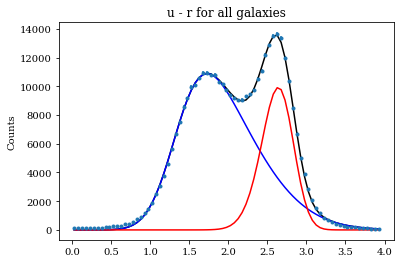

[ 1.35649620e+04  1.33444186e+00  7.95556831e-01  2.64464752e+00
  5.12803928e+03  2.78531191e+00  2.71703484e-01 -1.32351325e+00] [1.27953060e+02 5.04867943e-03 1.21130264e-02 8.57800919e-02
 9.91221173e+01 7.70034235e-03 8.01274336e-03 1.15373560e-01]


In [19]:
ur_all_fit = fit_bimodal(char_=vollim['u_r'],
                         bins=ur_bins, 
                         p0_=[10000, 1.5, 0.75, 0, 10000, 2.5, 0.5, 0], 
                         label='u - r for all galaxies')

In [44]:
blue_all = minimize_scalar(lambda x: -func_bimodal(x, *ur_all_fit[0]), bounds=(0,2), method='bounded')
red_all = minimize_scalar(lambda x: -func_bimodal(x, *ur_all_fit[0]), bounds=(2,4), method='bounded')

ur_ratio_all = blue_all.fun/red_all.fun
print(ur_ratio_all)

ur_ratio_all_approx, ur_ratio_all_err = ratio_uncertainty_approx(ur_all_fit[0], 
#ur_ratio_all_err = ratio_uncertainty(ur_all_fit[0], 
                                                                   ur_all_fit[1], 
                                                                   blue_all.x, 
                                                                   red_all.x)
print(ur_ratio_all_approx, ur_ratio_all_err)
#print(ur_ratio_all_err)

0.8019357552735801
0.8023538228639674 0.005072870017939692


## VoidFinder void

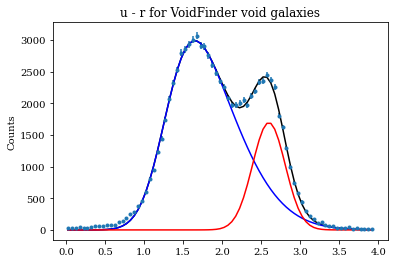

[3.35605113e+03 1.29528540e+00 7.03722038e-01 2.46216870e+00
 8.91250747e+02 2.59933134e+00 2.09540627e-01 4.75113153e-03] [5.29287148e+01 8.24686559e-03 2.26169516e-02 1.52669207e-01
 4.68637124e+01 4.67366176e+02 1.51057549e+00 2.79549841e+03]


In [22]:
ur_VF_fit = fit_bimodal(char_=catalog_main['u_r'],
                        class_=void_vf,
                        bins=ur_bins, 
                        p0_=[3000, 1.5, 0.75, 0, 3000, 2.5, 0.5, 0], 
                        label='u - r for VoidFinder void galaxies')

In [45]:
blue_VF = minimize_scalar(lambda x: -func_bimodal(x, *ur_VF_fit[0]), bounds=(0,2), method='bounded')
red_VF = minimize_scalar(lambda x: -func_bimodal(x, *ur_VF_fit[0]), bounds=(2,4), method='bounded')

ur_ratio_VF = blue_VF.fun/red_VF.fun
print(ur_ratio_VF)

ur_ratio_VF_approx, ur_ratio_VF_err = ratio_uncertainty_approx(ur_VF_fit[0], 
#ur_ratio_VF_err = ratio_uncertainty(ur_VF_fit[0], 
                                    ur_VF_fit[1], 
                                    blue_VF.x, 
                                    red_VF.x)
print(ur_ratio_VF_approx, ur_ratio_VF_err)
#print(ur_ratio_VF_err)

1.233458384292182
3.84564688533358 0.29193003557496144


## V$^2$ voids

6380


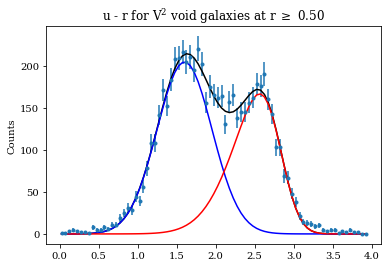

[ 1.80471536e+02  1.60021105e+00  3.52545795e-01  3.25944507e-03
  1.30337649e+02  2.81200568e+00  4.81210553e-01 -2.27641630e+00] [1.79492631e+01 1.23248179e+03 3.21128180e+00 4.38160532e+03
 1.75952133e+01 3.19167332e-02 1.07093604e-01 8.69175852e-01]
12636


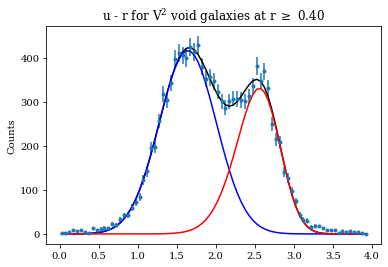

[ 3.82474453e+02  1.64415503e+00  3.65775505e-01 -3.91747543e-03
  2.34514895e+02  2.76825443e+00  3.83619562e-01 -1.47213497e+00] [2.10259196e+01 1.17074652e+03 3.65460090e+00 4.01160229e+03
 1.99614436e+01 3.76958611e-02 6.55968982e-02 5.42946804e-01]
20721


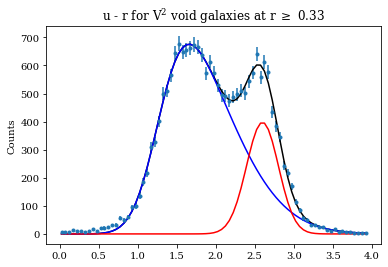

[ 8.12656883e+02  1.28067471e+00  7.73017220e-01  2.71803992e+00
  2.04629554e+02  2.66677019e+00  2.16452009e-01 -4.30769184e-01] [1.72364262e+01 1.05338912e-02 2.94128081e-02 2.06631877e-01
 1.39575414e+01 1.85348438e-01 6.29270736e-02 1.29595291e+00]
31104


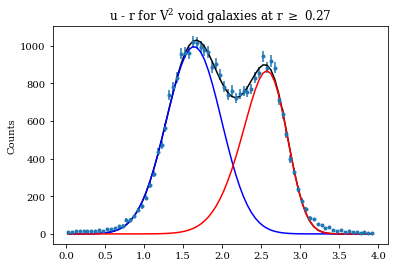

[ 8.81591905e+02  1.64009840e+00  3.53324720e-01  5.42815584e-06
  6.37002499e+02  2.80370814e+00  4.31713619e-01 -1.93190158e+00] [4.02656943e+01 1.13215114e+00 9.77275199e-03 4.01100180e+00
 3.81835382e+01 1.83277094e-02 4.66315450e-02 3.89561834e-01]
44538


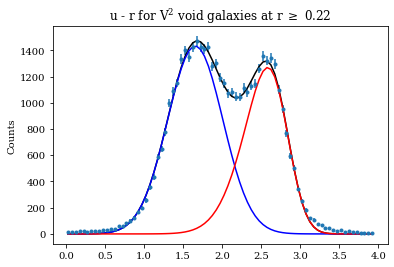

[ 1.27337251e+03  1.65501474e+00  3.54648873e-01  5.60293013e-03
  9.01541891e+02  2.80752972e+00  4.16070022e-01 -1.91358700e+00] [5.11890200e+01 4.35339180e+02 7.94092897e-01 1.53848284e+03
 4.83738503e+01 1.64617916e-02 4.04338764e-02 3.53291747e-01]
62095


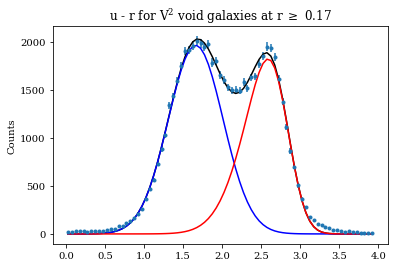

[ 1.73123065e+03  1.66196510e+00  3.51593638e-01  1.93899568e-03
  1.30057507e+03  2.81371095e+00  4.23286987e-01 -1.99973567e+00] [6.66663426e+01 1.83413579e+02 1.40481542e-01 6.53808413e+02
 6.30430310e+01 1.38073071e-02 3.62517078e-02 3.18254733e-01]
85110


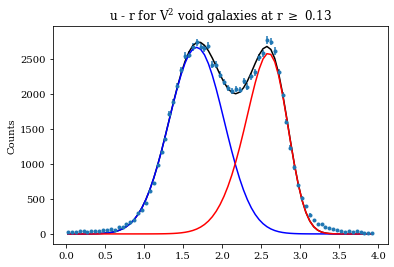

[ 2.36327638e+03  1.67560217e+00  3.53338328e-01 -5.71906465e-03
  1.79087259e+03  2.81138924e+00  4.05722515e-01 -1.91052377e+00] [9.65181308e+01 8.10148620e+02 3.07195034e+00 2.87378009e+03
 9.42213629e+01 1.41695100e-02 3.60970794e-02 3.16321217e-01]
115628


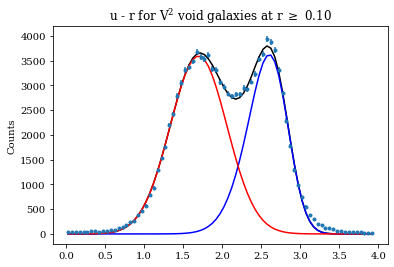

[ 2.36802376e+03  2.80469244e+00  3.69152101e-01 -1.68822344e+00
  3.28019985e+03  1.69992021e+00  3.64102191e-01 -2.34753616e-03] [9.18204029e+01 1.37184184e-02 2.71510507e-02 2.56353169e-01
 9.90800700e+01 4.62885962e+02 1.01129100e+00 1.59336163e+03]
156341


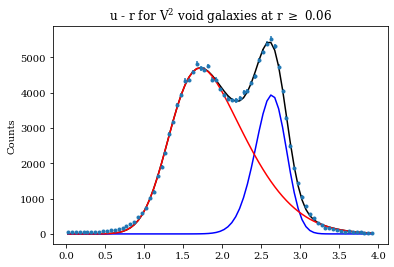

[ 1.99871436e+03  2.78437979e+00  2.73555571e-01 -1.44371365e+00
  5.70209842e+03  1.33801845e+00  7.78680848e-01  2.71313781e+00] [5.14120828e+01 8.51049945e-03 9.64697745e-03 1.43520308e-01
 6.58536454e+01 5.70373166e-03 1.44792721e-02 1.05519984e-01]
205744


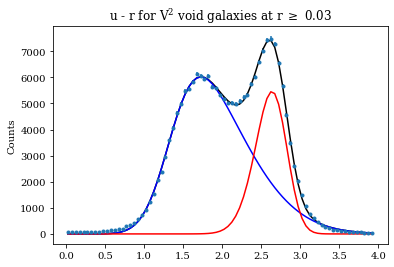

[ 7.35728012e+03  1.34331879e+00  7.85253547e-01  2.70740307e+00
  2.78915613e+03  2.79042930e+00  2.77097174e-01 -1.47424790e+00] [7.65716812e+01 5.25166886e-03 1.29701776e-02 9.47977154e-02
 5.94678738e+01 7.01633888e-03 8.13786554e-03 1.21261278e-01]
247281


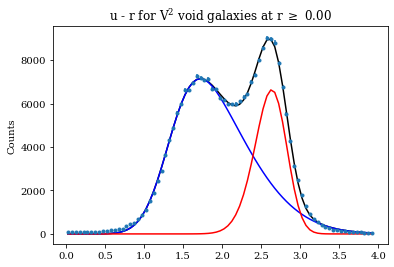

[ 8.75851384e+03  1.33555944e+00  7.90064190e-01  2.74894925e+00
  3.43216894e+03  2.78768248e+00  2.78857131e-01 -1.44503819e+00] [9.30880534e+01 5.25759037e-03 1.32182149e-02 9.71613965e-02
 7.24995315e+01 7.21781311e-03 8.21163690e-03 1.20195547e-01]


In [46]:
# Number of slices
N = 10

# Volume of inner-most slice (r = 0.5)
r_in = 0.5
V_in = r_in**3 # Normalized by 4/3*pi, since this is the volume of the entire volume

# volume-spacing
d_vol = (4./3.)*np.pi*(1 - V_in)/N

# Initialize variable that will store the previous radius value
r_limits = np.zeros(N+1, dtype=float)
r_limits[0] = r_in

# Initialize arrays that will store the ratios and uncertainties
ur_ratio_V2 = -1*np.ones(N+1, dtype=float)
ur_ratio_V2_err = np.zeros(N+1, dtype=float)

for i in range(N + 1):
    
    # Calculate minimum radius of this slice
    if i != 0:
        r_limits[i] = 1 - ((1 - r_limits[i - 1])**3 + (3*d_vol/(4*np.pi)))**(1./3.)
    
    # Select all V2 void galaxies with normalized void depths greater than or equal to this value
    gals_in = (catalog_main['V2_depth'] >= r_limits[i]) & void_v2
    print(np.sum(gals_in))
    
    # Fit this distribution
    ur_V2slice_fit = fit_bimodal(char_=catalog_main['u_r'], 
                                 class_=gals_in, 
                                 bins=ur_bins, 
                                 p0_=[0.1*np.sum(gals_in), 1.5, 0.75, -2.25, 0.1*np.sum(gals_in), 2.5, 0.5, -1.5], 
                                 label=r'u - r for V$^2$ void galaxies at r $\geq$ {:.2f}'.format(r_limits[i]))
    
    # Calculate local maxima
    blue = minimize_scalar(lambda x: -func_bimodal(x, *ur_V2slice_fit[0]), 
                           bounds=(0,2), 
                           method='bounded')
    red = minimize_scalar(lambda x: -func_bimodal(x, *ur_V2slice_fit[0]), 
                          bounds=(2,4), 
                          method='bounded')
    
    # Calculate ratio uncertainty
    ur_ratio_V2[i], ur_ratio_V2_err[i] = ratio_uncertainty_approx(ur_V2slice_fit[0], 
    #ur_ratio_V2_err[i] = ratio_uncertainty(ur_V2slice_fit[0], 
                                           ur_V2slice_fit[1], 
                                           blue.x, 
                                           red.x)
    
    # Calculate ratio
    ur_ratio_V2[i] = blue.fun/red.fun

## Plot results

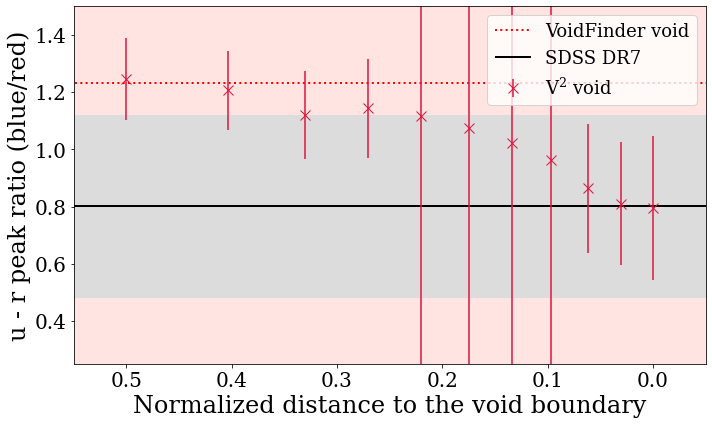

In [43]:
depth_plot(ur_ratio_VF, ur_ratio_VF_err, 
           ur_ratio_all, ur_ratio_all_err, 
           ur_ratio_V2, ur_ratio_V2_err, 
           r_limits, 
           y_label='u - r peak ratio (blue/red)', 
           #filename='sSFR_depth'
           )

plt.ylim(0.25,1.5);

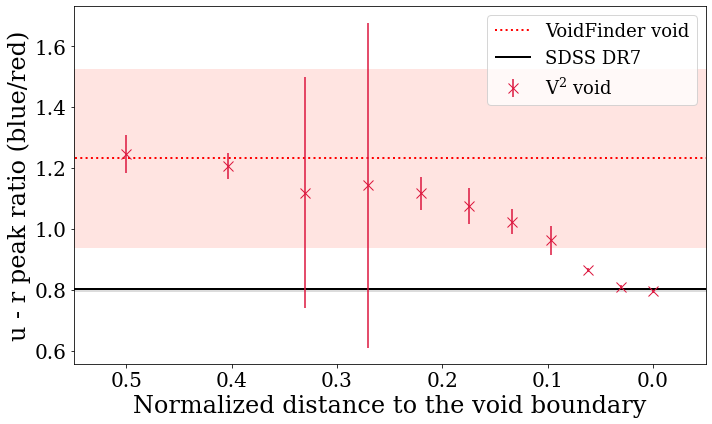

In [47]:
depth_plot(ur_ratio_VF, ur_ratio_VF_err, 
           ur_ratio_all, ur_ratio_all_err, 
           ur_ratio_V2, ur_ratio_V2_err, 
           r_limits, 
           #fillbetween=True, 
           y_label='u - r peak ratio (blue/red)', 
           #filename='ur_depth'
           )

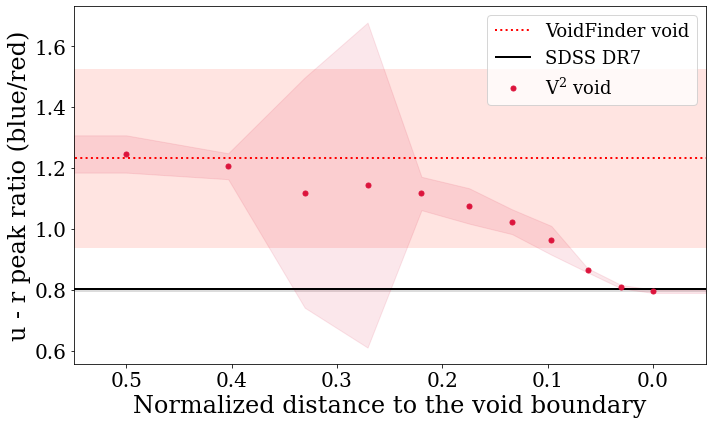

In [48]:
depth_plot(ur_ratio_VF, ur_ratio_VF_err, 
           ur_ratio_all, ur_ratio_all_err, 
           ur_ratio_V2, ur_ratio_V2_err, 
           r_limits, 
           fillbetween=True, 
           y_label='u - r peak ratio (blue/red)', 
           #filename='ur_depth'
           )